In [80]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [111]:
#download dataset from yahoo finance 
df = pd.read_csv(r"C:\Users\tarun\Desktop\MSFT.csv")

In [112]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060980,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063158,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.064247,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.062613,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061524,47894400


In [113]:
df1 = df.reset_index()['Close']

In [114]:
df1

0         0.097222
1         0.100694
2         0.102431
3         0.099826
4         0.098090
           ...    
9182    291.320007
9183    290.170013
9184    286.149994
9185    277.750000
9186    276.440002
Name: Close, Length: 9187, dtype: float64

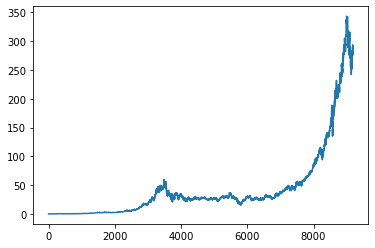

In [115]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [116]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scalar = MinMaxScaler(feature_range=(0,1))
df1 = scalar.fit_transform(np.array(df1).reshape(-1,1))

In [117]:
df1.shape

(9187, 1)

In [118]:
df1

array([[2.02437349e-05],
       [3.03656023e-05],
       [3.54294513e-05],
       ...,
       [8.33945427e-01],
       [8.09457055e-01],
       [8.05638039e-01]])

In [119]:
training_size = int(len(df1)*0.65)
test_size = len(df1) - training_size
train_data ,test_data = df1[0:training_size,:],df1[training_size:len(df1),:1]

In [120]:
len(train_data)

5971

In [121]:
def create_dataset(dataset,time_step = 1):
    dataX , dataY = [],[]
    
    for i in range(len(dataset) -time_step -1):
        a = dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
    return np.array(dataX),np.array(dataY)

In [122]:
time_step = 100
X_train,y_train = create_dataset(train_data,time_step)
X_test,y_test = create_dataset(test_data,time_step)

In [123]:
print(X_test.shape),print(y_test.shape)

(3115, 100)
(3115,)


(None, None)

In [124]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [125]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , LSTM

In [126]:
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mse',optimizer = 'adam')

In [127]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_7 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [128]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs = 10, batch_size = 32)

Epoch 1/10
184/184 [==============================] - 27s 102ms/step - loss: 1.0166e-04 - val_loss: 0.0045
Epoch 2/10
184/184 [==============================] - 18s 98ms/step - loss: 2.0383e-05 - val_loss: 0.0055
Epoch 3/10
184/184 [==============================] - 19s 101ms/step - loss: 1.8236e-05 - val_loss: 0.0057
Epoch 4/10
184/184 [==============================] - 18s 97ms/step - loss: 1.5508e-05 - val_loss: 0.0054
Epoch 5/10
184/184 [==============================] - 18s 95ms/step - loss: 1.2991e-05 - val_loss: 0.0038
Epoch 6/10
184/184 [==============================] - 18s 96ms/step - loss: 1.1633e-05 - val_loss: 0.0034
Epoch 7/10
184/184 [==============================] - 18s 96ms/step - loss: 1.1092e-05 - val_loss: 0.0052
Epoch 8/10
184/184 [==============================] - 18s 96ms/step - loss: 1.0948e-05 - val_loss: 0.0031
Epoch 9/10
184/184 [==============================] - 18s 97ms/step - loss: 8.8859e-06 - val_loss: 0.0016
Epoch 10/10
184/184 [=======================

In [129]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

98/98 [==============================] - 3s 26ms/step


In [130]:

train_predict = scalar.inverse_transform(train_predict)
test_predict = scalar.inverse_transform(test_predict)

In [131]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

21.52196853653501

In [132]:
#test data rmse
math.sqrt(mean_squared_error(y_test,test_predict))

112.87868383701189

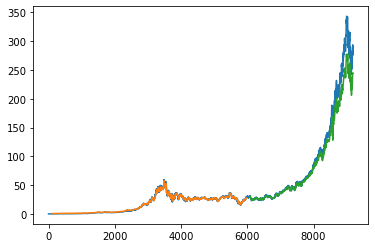

In [133]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scalar.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [134]:
len(test_data)

3216

In [135]:
x_input = test_data[3116:].reshape(1,-1)
x_input.shape

(1, 100)

In [136]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [137]:
temp_input

[0.8985481408506947,
 0.9017841502616641,
 0.9179639436867691,
 0.9060404421603684,
 0.8728644911354905,
 0.8783160583831997,
 0.8654888245240092,
 0.8313508704617955,
 0.8220219254050032,
 0.838230897911647,
 0.8155208091294884,
 0.8175323611946297,
 0.8314674177014558,
 0.8345576104174097,
 0.8183778199075893,
 0.7986121946049006,
 0.8181154530576287,
 0.787504966879352,
 0.8254036640524565,
 0.8440906487043324,
 0.8087865080008363,
 0.8290477695498704,
 0.8212056486888667,
 0.8451110157353147,
 0.8082909592130227,
 0.8006529286668652,
 0.771062722061039,
 0.7854059591975572,
 0.7593141288526609,
 0.7441547024585384,
 0.7609758613664726,
 0.7620836840141083,
 0.7775930174180925,
 0.7404522796120283,
 0.7377119035321198,
 0.7360210356660355,
 0.7596056747841605,
 0.7566029347695759,
 0.7650572420318698,
 0.7749109178732988,
 0.7963090936929755,
 0.792315168644232,
 0.7939186275382132,
 0.80021556604035,
 0.786921875016353,
 0.7832194958991089,
 0.7941518123913505,
 0.7880588796608121,

In [138]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        #we are taking temp_input[1:] to shift value to next side
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1,n_steps ,1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.700082]
101
1 day input [0.90178415 0.91796394 0.90604044 0.87286449 0.87831606 0.86548882
 0.83135087 0.82202193 0.8382309  0.81552081 0.81753236 0.83146742
 0.83455761 0.81837782 0.79861219 0.81811545 0.78750497 0.82540366
 0.84409065 0.80878651 0.82904777 0.82120565 0.84511102 0.80829096
 0.80065293 0.77106272 0.78540596 0.75931413 0.7441547  0.76097586
 0.76208368 0.77759302 0.74045228 0.7377119  0.73602104 0.75960567
 0.75660293 0.76505724 0.77491092 0.79630909 0.79231517 0.79391863
 0.80021557 0.78692188 0.7832195  0.79415181 0.78805888 0.771675
 0.73727463 0.7059936  0.71249471 0.7336888  0.71389404 0.72170698
 0.73946109 0.73768277 0.75438729 0.78015848 0.77196654 0.74744899
 0.75846876 0.74846927 0.7564863  0.76601934 0.77581465 0.78219913
 0.78004185 0.77085872 0.739257   0.73648749 0.74045228 0.74814863
 0.74094787 0.75634057 0.76432842 0.77182072 0.75876022 0.75429984
 0.73409694 0.78319031 0.80555059 0.81817373 0.81021506 0.80091529
 0.8232172  0.82665722 0.82449993 0.8

In [139]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [140]:
len(df1)

9187

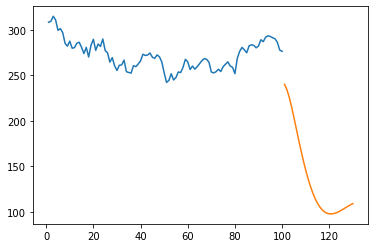

In [141]:

plt.plot(day_new,scalar.inverse_transform(df1[9087:]))
plt.plot(day_pred,scalar.inverse_transform(lst_output))

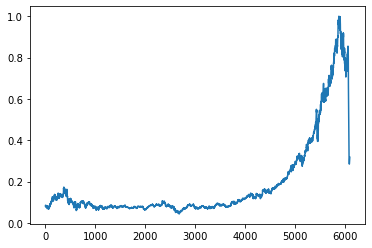

In [142]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[3116:])

In [143]:
df3=scalar.inverse_transform(df3).tolist()

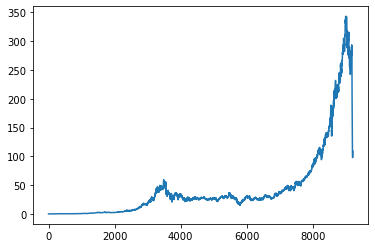

In [144]:
plt.plot(df3)